In [255]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.graph_objects as go
import geoplot
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# DataSet Utilizado Para a Análize
### https://www.kaggle.com/ronnycfs/ocorrencias-aviacao-civil-brasileira

In [256]:
base = pd.read_csv('ocoraero.csv')
base.head()

,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_tipo_categoria,ocorrencia_tipo_icao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,...,ocorrencia_horario,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_dia_extracao
0,201305055424986,ACIDENTE,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP,-9.9085,-63.0333,ARIQUEMES,RO,BRASIL,...,11:00:00,NaN,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2018-08-28
1,201605160250139,INCIDENTE GRAVE,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,CTOL,-11.2644,-61.2589,CACOAL,RO,BRASIL,...,19:19:00,SIM,ATIVA,IG-084/CENIPA/2016,NÃO,NaN,0,1,NÃO,2018-08-28
2,201805021421302,INCIDENTE,AERÓDROMO,AERÓDROMO,ADRM,-11.4956,-61.4508,CACOAL,RO,BRASIL,...,22:40:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2018-08-28
3,201311259977425,INCIDENTE GRAVE,POUSO SEM TREM,CONTATO ANORMAL COM A PISTA,ARC,-11.4956,-61.4508,CACOAL,RO,BRASIL,...,12:32:00,NaN,FINALIZADA,IG-209/CENIPA/2013,SIM,2014-04-07,0,1,NÃO,2018-08-28
4,201103187273112,INCIDENTE,OUTROS,OUTROS,OTHR,-13.1950,-60.8184,CEREJEIRAS,RO,BRASIL,...,13:30:00,NaN,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2018-08-28


### Para melhor álise são separado os dados desejados, assim como realizado o processo de normalização dos dados.

In [257]:
coordenadas = base.iloc[:,[5,6]].values
scaler = StandardScaler()
coordenadas = scaler.fit_transform(coordenadas)
coordenadas

array([[ 0.94938732, -1.36385422],
       [ 0.79203911, -1.20891651],
       [ 0.76520903, -1.22567291],
       ...,
       [ 2.09923961,  4.14011055],
       [ 2.09923961,  4.14011055],
       [ 2.87813587,  1.25931175]])

In [258]:
Latitudes =base.iloc[:,[5,6]].values
Latitudes

array([[ -9.9085, -63.0333],
       [-11.2644, -61.2589],
       [-11.4956, -61.4508],
       ...,
       [  0.    ,   0.    ],
       [  0.    ,   0.    ],
       [  6.7119, -32.9919]])

### Realizado aplicação da técnica de apoio a escolha do "K" cluster Elbow Method -WSCC(Whith-cluster sum of Squares)

In [259]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(coordenadas)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

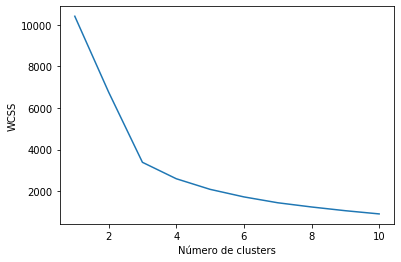

In [260]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')

### Treinamento do augorítimo K-means++

In [261]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
previsoes = kmeans.fit_predict(coordenadas)

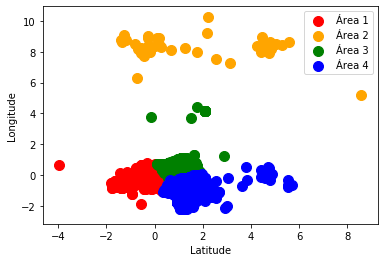

In [262]:
plt.scatter(coordenadas[previsoes == 0, 0], coordenadas[previsoes == 0, 1], s = 100, c = 'red', label = 'Área 1')
plt.scatter(coordenadas[previsoes == 1, 0], coordenadas[previsoes == 1, 1], s = 100, c = 'orange', label = 'Área 2')
plt.scatter(coordenadas[previsoes == 2, 0], coordenadas[previsoes == 2, 1], s = 100, c = 'green', label = 'Área 3')
plt.scatter(coordenadas[previsoes == 3, 0], coordenadas[previsoes == 3, 1], s = 100, c = 'blue', label = 'Área 4')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

### União de resultados do treinamento com dados relacionados

In [263]:
valores = pd.DataFrame(np.column_stack((base.iloc[:,[7,5,6]].values, previsoes)))
valores.columns = ['cidade','latitude', 'longitude', 'clasificação']

print(valores[valores['clasificação'] ==0].shape)
print(valores[valores['clasificação'] ==1].shape)
print(valores[valores['clasificação'] ==2].shape)
print(valores[valores['clasificação'] ==3].shape)

(3847, 4)
(48, 4)
(603, 4)
(710, 4)


In [264]:
valores_classificacao = pd.DataFrame(np.column_stack((base.iloc[:,[7,5,6,1,2]].values, previsoes)))
valores_classificacao.columns = ['cidade','latitude', 'longitude', 'ocorrencia_classificacao','ocorrencia_tipo_categoria', 'clasificação']

### Separado apenas os Clusters com a maior e menor quantidade de ocorências respectivamente.

In [265]:
maior_frequencia = valores[valores['clasificação'] == 0]
maior_frequencia['longitude'].values

array([-54.2125, -49.4405, -44.2806, ..., -55.5728, -55.5478, -47.1967],
      dtype=object)

In [266]:
menor_frequencia = valores[valores['clasificação'] == 1]
menor_frequencia['longitude'].values

array([47.9186, 48.7575, 41.3078, 55.1939, 48.9281, 47.2681, 55.6725,
       54.5242, 47.3347, 48.1636, 69.8506, 46.5742, 38.5322, 43.1628,
       43.2506, 54.4922, 52.8156, 58.0967, 48.5958, 35.5839, 53.5522,
       43.9936, 43.9506, 43.9506, 46.1614, 49.5147, 11.8667, 54.7242,
       49.3494, 46.8181, 56.4672, 44.4092, 51.4919, 51.2881, 52.685,
       51.2039, 50.0158, 45.8922, 50.1436, 46.9436, 47.9797, 24.38,
       49.4686, 46.9047, 49.3989, 47.9569, 46.6564, 46.6342], dtype=object)

### Montagem do GeoDataFrame do GeoPandas para visualização dos dados.

In [267]:
df = pd.DataFrame({'city': maior_frequencia['cidade'].values,
                   'latitude': maior_frequencia['latitude'].values,
                   'longitude': maior_frequencia['longitude'].values})

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

In [268]:
df2 = pd.DataFrame({'city': menor_frequencia['cidade'].values,
                   'latitude': menor_frequencia['latitude'].values,
                   'longitude': menor_frequencia['longitude'].values})

geometry2 = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]

In [269]:
gdf = gpd.GeoDataFrame(df.drop(['latitude', 'longitude'], axis=1),
                       crs={'init': 'epsg:2262'},
                       geometry=geometry)

In [270]:
gdf2 = gpd.GeoDataFrame(df2.drop(['latitude', 'longitude'], axis=1),
                       crs={'init': 'epsg:2262'},
                       geometry=geometry2)

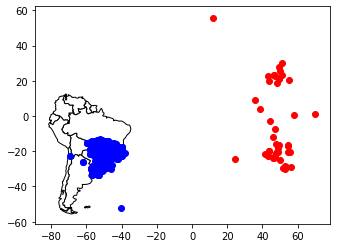

In [271]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

ax.set_aspect('equal')

gdf.plot(ax=ax, color='blue')
gdf2.plot(ax=ax, color='red')
plt.show();

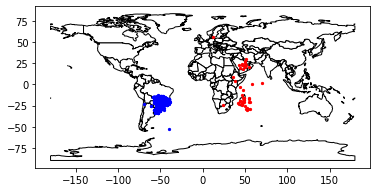

In [272]:
base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='blue', markersize=5)
gdf2.plot(ax=base, marker='o', color='red',markersize=5)
plt.show()

### Análise dos dados do gluster com maior quantidade de ocorrências. 

In [273]:
grupo_ocorrencias = valores_classificacao.groupby('ocorrencia_tipo_categoria')['ocorrencia_tipo_categoria'].size() > 200
grupo_ocorrencias.sort_values(ascending=True)
grupo_ocorrencias.head()

ocorrencia_tipo_categoria
AERONAVE ATINGIDA POR OBJETO                   False
AERÓDROMO                                      False
ALARME FALSO DE FOGO OU DE SUPERAQUECIMENTO    False
CAUSADO POR FENÔMENO METEOROLÓGICO EM VOO      False
CAUSADO POR FENÔMENO METEOROLÓGICO NO SOLO     False
Name: ocorrencia_tipo_categoria, dtype: bool

In [274]:
valor = pd.DataFrame(grupo_ocorrencias)
ass = valor[valor['ocorrencia_tipo_categoria'] == True]
ass.head(20)

,ocorrencia_tipo_categoria
ocorrencia_tipo_categoria,
COM TREM DE POUSO,True
ESTOURO DE PNEU,True
FALHA DO MOTOR EM VOO,True
FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE,True
OUTROS,True
PERDA DE CONTROLE EM VOO,True
PERDA DE CONTROLE NO SOLO,True


In [275]:
grupo_categorio = valores_classificacao.groupby('ocorrencia_classificacao')['ocorrencia_classificacao'].size()
grupo_categorio.sort_values(ascending=True)
grupo_categorio.head(10)

ocorrencia_classificacao
ACIDENTE           1714
INCIDENTE          2861
INCIDENTE GRAVE     633
Name: ocorrencia_classificacao, dtype: int64

In [276]:
grupo_ocorrencias = valores_classificacao.groupby('clasificação')['clasificação'].size()
grupo_ocorrencias.head()

clasificação
0    3847
1      48
2     603
3     710
Name: clasificação, dtype: int64